In [22]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Flatten, Dropout, Input
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import ExtraTreesClassifier


import numpy as np
import pandas as pd


# List files in the directory to identify the file
directory = '/kaggle/input/dataset'
files = os.listdir(directory)


# Select the CSV file from the list of files
csv_file = [file for file in files if file.endswith('.csv')][0]  

# Load the data from the CSV file into a pandas DataFrame
df = pd.read_csv(os.path.join(directory, csv_file))# Assuming the 'target' column contains the labels
X = df.drop('target', axis=1).values



Y = df['target'].values

# Remove records containing null values
df.dropna(inplace=True)

# Outlier detection and removal using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Separate features (X) and target (Y) from the DataFrame
X = df_no_outliers.drop('target', axis=1).values
Y = df_no_outliers['target'].values

# Preprocess the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Feature selection using Extra Trees Classifier
etc = ExtraTreesClassifier(random_state=42)
etc.fit(X_scaled, Y)

# Retrieve feature importances
feature_importances = etc.feature_importances_

# Select top k features (adjust k as needed)
k = 10
top_k_indices = feature_importances.argsort()[-k:][::-1]

# Filter features to keep only the selected top k features
X_selected = X_scaled[:, top_k_indices]
# Split the data into training and test sets
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, test_size=0.2, random_state=42)
# Define the model architecture
model = Sequential()
model.add(Input(shape=(12, 1)))  
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(LSTM(128, activation='tanh'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# Train the model on the training data
model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.6085 - loss: 0.6751 - val_accuracy: 0.7444 - val_loss: 0.5675
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7231 - loss: 0.5692 - val_accuracy: 0.8111 - val_loss: 0.4335
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7480 - loss: 0.5253 - val_accuracy: 0.8111 - val_loss: 0.4090
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7862 - loss: 0.4845 - val_accuracy: 0.8111 - val_loss: 0.4106
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7823 - loss: 0.4696 - val_accuracy: 0.8000 - val_loss: 0.4079
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7731 - loss: 0.4951 - val_accuracy: 0.8222 - val_loss: 0.3923
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7430 - loss: 0.4691 - val_accuracy: 0.8333 - val_loss: 0.3812
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8097 - loss: 0.4182 - val_accuracy: 0.8222 - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9015 - loss: 0.3095 
Test accuracy: 0.8839285969734192
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
AUC Score: 0.9387096774193548


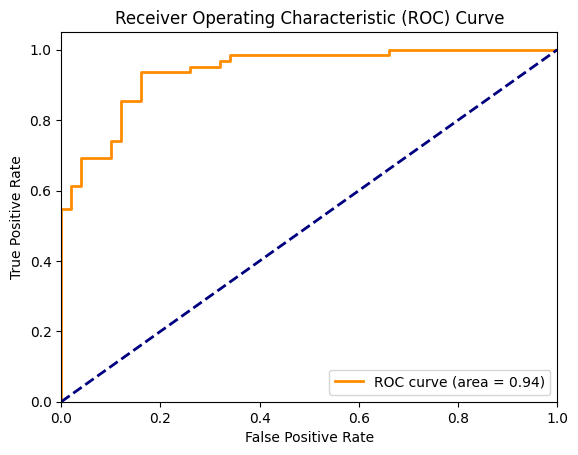

In [23]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test accuracy:', accuracy)
# Get predicted probabilities for the test set
Y_pred_prob = model.predict(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)

# Print AUC score
print("AUC Score:", roc_auc)

# Plot ROC curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
# Assuming you have a new input in the same format as the original data
new_input = np.array([[48,0,4,138,214,0,0,108,1,1.5,2]], dtype=float)
# Preprocess the new input
new_input = scaler.transform(new_input)
# Test the model for the new input
model_output = model.predict(new_input)
# Print the predicted label
predicted_label = np.round(model_output).astype(int)

if predicted_label==1:
    print("Heart disease present")
else:
    print("Normal")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Heart disease present
